In [1]:
import pickle

from lmfit.models import GaussianModel
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import pandas as pd

from mint.snapshot import SnapshotDB

In [2]:
# Reduce originally recorded data to a simple and readable DataFrame of only what I need
snapshot_db = SnapshotDB("original/20210221-01_30_17_scan_phase1.pcl")
tds = snapshot_db.load()

is_beam_on = tds["XFEL.UTIL/BUNCH_PATTERN/CONTROL/BEAM_ALLOWED"].astype("bool")
l1_chirp_phase = tds["XFEL.RF/LLRF.SUMVOLTAGE_CTRL/L1/SUMVOLTAGE.CHIRP.SP.1"]
charge = tds["XFEL.DIAG/CHARGE.ML/TORA.25.I1/CHARGE.ALL"]
tds_image = tds["XFEL.DIAG/CAMERA/OTRA.473.B2D/IMAGE_EXT_ZMQ"].apply(lambda path: pickle.load(open("original/"+path[2:-4]+".pcl", "rb")))

tds_reduced = pd.DataFrame({"is_beam_on": is_beam_on,
                        "l1_chirp_phase": l1_chirp_phase,
                        "charge": charge,
                        "tds_image": tds_image})
tds_reduced

,is_beam_on,l1_chirp_phase,charge,tds_image
0,True,-7.0,0.24685,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 4, 13, ..."
1,False,-7.0,NaN,"[[12, 5, 4, 4, 14, 6, 0, 0, 1, 14, 9, 0, 0, 12..."
2,False,-7.0,NaN,"[[0, 12, 0, 0, 14, 0, 18, 18, 11, 0, 24, 9, 0,..."
3,False,-7.0,NaN,"[[0, 0, 3, 0, 15, 9, 0, 0, 9, 0, 22, 18, 17, 0..."
4,False,-7.0,NaN,"[[2, 0, 0, 0, 15, 11, 0, 0, 30, 0, 0, 0, 0, 11..."
...,...,...,...,...
191,True,5.0,0.24900,"[[0, 6, 1, 0, 17, 1, 0, 13, 0, 0, 13, 0, 0, 0,..."
192,True,5.0,0.25455,"[[0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 25, 0, 0, 0, 1..."
193,True,5.0,0.25890,"[[0, 0, 0, 0, 22, 11, 0, 0, 0, 1, 26, 0, 0, 7,..."
194,True,5.0,0.24915,"[[0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [3]:
background = tds_reduced.loc[1:6,"tds_image"].mean()

preprocessed = tds_reduced.loc[6:,["l1_chirp_phase","charge","tds_image"]].copy()

# Average all five images per chirp setting
preprocessed = preprocessed.groupby("l1_chirp_phase").apply(np.mean).drop("l1_chirp_phase", axis=1)
preprocessed["tds_image"] = preprocessed["tds_image"].apply(lambda image: image.clip(0, 4095))

# Remove background
remove_background = lambda image: (image - background).clip(0, 4095)
preprocessed["tds_image"] = preprocessed["tds_image"].apply(remove_background)

# Denoise images
def denoise(image):
    denoised = ndimage.uniform_filter(image, size=12)
    denoised[denoised < 0.05 * denoised.max()] = 0
    return denoised

preprocessed["tds_image"] = preprocessed["tds_image"].apply(denoise)

# Extract current profiles
def extract_current_profile(row):
    seconds_per_pixel = 0.0438912 * 10e-12

    view = row["tds_image"].sum(axis=0)
    current = row["charge"] * 10e-9 / seconds_per_pixel * view / view.sum()

    xs = np.arange(len(current))
    model = GaussianModel()
    guess = model.guess(current, x=xs)
    fit = model.fit(current, guess, x=xs)

    low = int(fit.params["center"].value - 4 * fit.params["sigma"].value)
    high = int(fit.params["center"].value + 4 * fit.params["sigma"].value)
    extracted = current[low:high]

    return extracted

preprocessed = preprocessed.apply(extract_current_profile, axis=1)
preprocessed

l1_chirp_phase
-12.0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-11.5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-11.0    [9.079330720215614, 9.399006934503833, 9.67279...
-10.5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-10.0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-9.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-9.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-8.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-8.0     [0.0, 0.9334706779521185, 1.7374869286994412, ...
-7.5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-7.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-6.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-5.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-3.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
-1.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 2.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
 5.0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

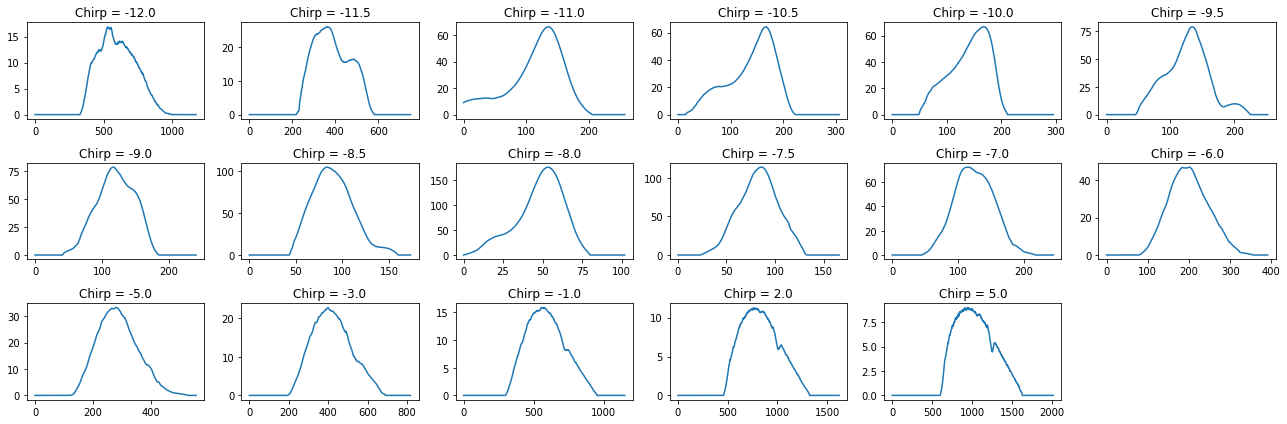

In [4]:
plt.figure(figsize=(18,6))
for i, chirp in enumerate(preprocessed.index.values):
    plt.subplot(3, 6, i+1)
    plt.title(f"Chirp = {chirp}")
    plt.plot(preprocessed[chirp])
plt.tight_layout()
plt.show()

In [5]:
snapshot_db = SnapshotDB("original/20210221-02_11_54_scan_CRISP_low.pcl")
crisp_low = snapshot_db.load()

l1_chirp_phase = crisp_low["XFEL.RF/LLRF.SUMVOLTAGE_CTRL/L1/SUMVOLTAGE.CHIRP.SP.1"]
form_factor = crisp_low["XFEL.SDIAG/THZ_SPECTROMETER.FORMFACTOR/CRD.1934.TL/FORMFACTOR.XY"]

crisp_low_reduced = pd.DataFrame({"l1_chirp_phase": l1_chirp_phase,
                                  "form_factor": form_factor})
crisp_low_reduced

,l1_chirp_phase,form_factor
0,-7.0,"[[0.684283, 1.4530452], [0.6863423, 3.7493443]..."
1,-12.0,"[[0.684283, 5.03848], [0.6863423, 3.058674], [..."
2,-12.0,"[[0.684283, -0.6827929], [0.6863423, 0.1092604..."
3,-12.0,"[[0.684283, 1.5086796], [0.6863423, -0.2494656..."
4,-12.0,"[[0.684283, 1.348622], [0.6863423, 2.408593], ..."
...,...,...
946,5.0,"[[0.684283, -0.50114834], [0.6863423, -0.18133..."
947,5.0,"[[0.684283, 0.76443475], [0.6863423, 1.248048]..."
948,5.0,"[[0.684283, -0.056538783], [0.6863423, -0.1150..."
949,5.0,"[[0.684283, -1.507832], [0.6863423, 1.0963312]..."


In [6]:
snapshot_db = SnapshotDB("original/20210221-02_02_12_scan_CRISP_high.pcl")
crisp_high = snapshot_db.load()

l1_chirp_phase = crisp_high["XFEL.RF/LLRF.SUMVOLTAGE_CTRL/L1/SUMVOLTAGE.CHIRP.SP.1"]
form_factor = crisp_high["XFEL.SDIAG/THZ_SPECTROMETER.FORMFACTOR/CRD.1934.TL/FORMFACTOR.XY"]

crisp_high_reduced = pd.DataFrame({"l1_chirp_phase": l1_chirp_phase,
                                   "form_factor": form_factor})
crisp_high_reduced

,l1_chirp_phase,form_factor
0,-7.0,"[[0.684283, 2.6642845], [0.6863423, 0.6672025]..."
1,-12.0,"[[0.684283, 0.14918189], [0.6863423, 0.0189832..."
2,-12.0,"[[0.684283, 7.364043], [0.6863423, 6.0359282],..."
3,-12.0,"[[0.684283, 2.6741476], [0.6863423, 2.6755598]..."
4,-12.0,"[[0.684283, -3.1175277], [0.6863423, 2.6539419..."
...,...,...
946,5.0,"[[0.684283, -0.62241614], [0.6863423, -0.75240..."
947,5.0,"[[0.684283, 2.2379296], [0.6863423, -0.3506040..."
948,5.0,"[[0.684283, 0.07262466], [0.6863423, 0.0092414..."
949,5.0,"[[0.684283, 4.0536], [0.6863423, 3.3225276], [..."


In [7]:
frequencies = crisp_low_reduced.loc[0,"form_factor"][:,0]

combined = crisp_low_reduced[1:][["l1_chirp_phase","form_factor"]].copy()

# Remove frequencies from XY data recorded from machine
remove_frequencies = lambda data: data[:, 1]
combined["form_factor_low"] = combined["form_factor"].apply(remove_frequencies)
combined.drop("form_factor", axis=1, inplace=True)
combined["form_factor_high"] = crisp_high_reduced[1:]["form_factor"].apply(remove_frequencies)

# Combine the high and low form factors to a single complete one
def combine_form_factors(row):
    return np.concatenate([row["form_factor_low"][:120], row["form_factor_high"][120:]])

combined["form_factor"] = combined.apply(combine_form_factors, axis=1)
combined.drop(["form_factor_low", "form_factor_high"], axis=1, inplace=True)

combined

,l1_chirp_phase,form_factor
1,-12.0,"[5.03848, 3.058674, -3.2622395, 0.3406048, 1.1..."
2,-12.0,"[-0.6827929, 0.10926041, -0.8235138, 0.5462018..."
3,-12.0,"[1.5086796, -0.24946564, 1.638597, -1.5877224,..."
4,-12.0,"[1.348622, 2.408593, 6.658132, -0.09190628, -1..."
5,-12.0,"[3.3360357, 3.8052037, -6.41254, -0.47265285, ..."
...,...,...
946,5.0,"[-0.50114834, -0.1813336, -1.4195234, 1.071323..."
947,5.0,"[0.76443475, 1.248048, -1.3205945, 1.4769993, ..."
948,5.0,"[-0.056538783, -0.115011886, 1.2003117, -0.509..."
949,5.0,"[-1.507832, 1.0963312, 0.017731637, 0.2107829,..."


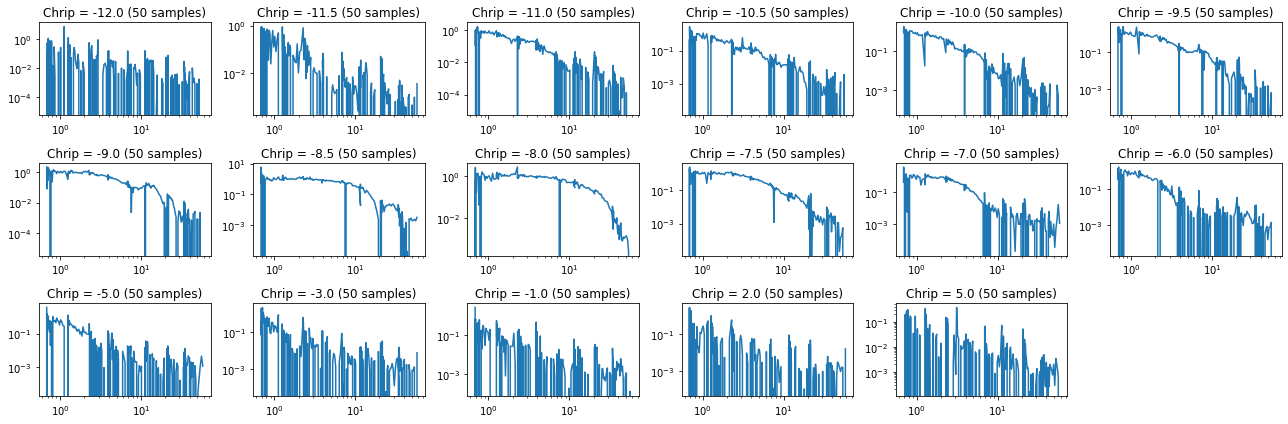

In [8]:
samples_per_chirp = len(combined[combined["l1_chirp_phase"] == chirp])
j = np.random.randint(samples_per_chirp)

plt.figure(figsize=(18,6))
for i, chirp in enumerate(combined["l1_chirp_phase"].unique()):
    plt.subplot(3, 6, i+1)
    plt.title(f"Chrip = {chirp} ({samples_per_chirp} samples)")
    form_factor = combined[combined["l1_chirp_phase"] == chirp].iloc[j]["form_factor"]
    plt.loglog(frequencies, form_factor)
plt.tight_layout()
plt.show()

In [ ]:
# Here is potential to combine every combination if highs and lows of on chirp value
# in order to provide more training data.

In [ ]:
# Must fix time calibration

In [ ]:
# Must check if chirps are actually correct or data was collected with different chirp settings

In [4]:
# Unite bunch profiles, CRISP high and CRISP low